In [2]:
import covid_feature_extraction
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.vector_ar.var_model import VAR

In [15]:
alloc_dates, state_y, first_dose = covid_feature_extraction.first_dose("Georgia","GA","Population")
alloc_dates, state_y, second_dose = covid_feature_extraction.second_dose("Georgia","GA","Population")
dates, state_y, state_X, feature_labels = covid_feature_extraction.state_extraction("Population")

dose_allocations = first_dose+second_dose

padded_doses = np.pad(dose_allocations,pad_width=(state_X.shape[0]-len(dose_allocations),0))
state_X = pd.concat([state_X,pd.Series(padded_doses,name="vaccine_allocations")],axis=1)

feature_labels += ["Vaccine Allocations"]

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [64]:
state_y.name

'Population Not Staying at Home'

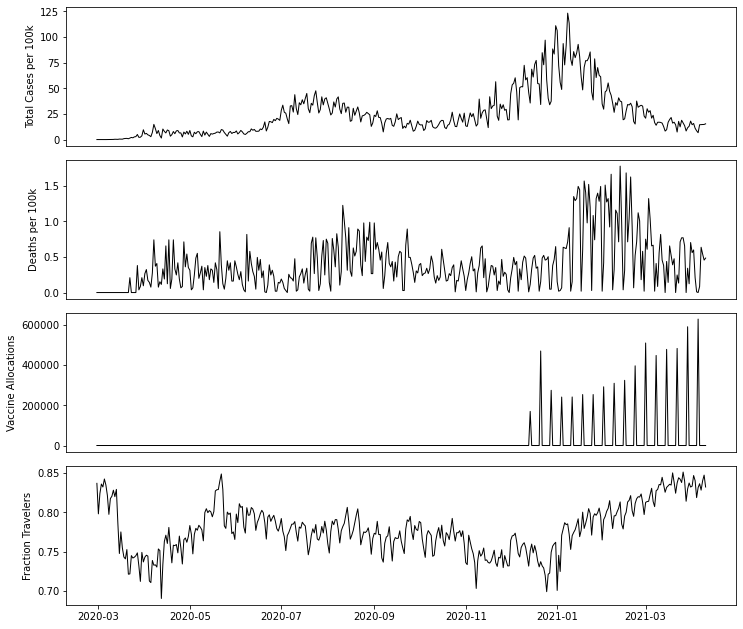

In [16]:
fig, ax = plt.subplots(4,1,figsize=(12,11))

ax[0].plot(dates,state_X["total_cases"],color='k',lw=1)
ax[0].tick_params(axis='x',bottom=False,labelbottom=False)
ax[0].set_ylabel("Total Cases per 100k")

ax[1].plot(dates,state_X["deaths"],color='k',lw=1)
ax[1].tick_params(axis='x',bottom=False,labelbottom=False)
ax[1].set_ylabel("Deaths per 100k")

ax[2].plot(dates,state_X["vaccine_allocations"],color='k',lw=1)
ax[2].tick_params(axis='x',bottom=False,labelbottom=False)
ax[2].set_ylabel("Vaccine Allocations")

ax[3].plot(dates,state_y,color='k',lw=1)
ax[3].set_ylabel("Fraction Travelers")

plt.subplots_adjust(hspace = 0.1)
plt.show()

In [17]:
# this sees if "total_cases" granger causes state_y
combined_data = pd.concat([state_y.reset_index(drop=True),state_X["total_cases"]],axis=1)
gct = grangercausalitytests(combined_data,maxlag=15,verbose=False)
p_val_dict = {}
for key in gct.keys():
    p_value = gct[key][0]['ssr_ftest'][1]
    p_val_dict[key] = p_value
p_val_dict

{1: 0.01664464515004257,
 2: 0.015711686171860546,
 3: 0.11787050816503103,
 4: 0.013476471064061421,
 5: 0.004784994785203016,
 6: 2.7147360346909922e-11,
 7: 1.7716772569696635e-08,
 8: 2.5189039454051904e-06,
 9: 6.965117083338334e-06,
 10: 1.9436559789961613e-05,
 11: 2.732762878511572e-05,
 12: 5.500653331252342e-05,
 13: 1.2474928551502117e-05,
 14: 4.902961457979399e-06,
 15: 9.424028785329021e-05}

In [18]:
# this sees if "deaths" granger causes state_y
combined_data = pd.concat([state_y.reset_index(drop=True),state_X["deaths"]],axis=1)
gct = grangercausalitytests(combined_data,maxlag=15,verbose=False)
p_val_dict = {}
for key in gct.keys():
    p_value = gct[key][0]['ssr_ftest'][1]
    p_val_dict[key] = p_value
p_val_dict

{1: 0.02218384683332743,
 2: 0.048114749202495366,
 3: 0.25336940094190036,
 4: 0.3816023314315999,
 5: 0.08186886116226523,
 6: 0.00044784925078271296,
 7: 1.560176278509157e-06,
 8: 0.009565763609518833,
 9: 0.04242351775160613,
 10: 0.06934951348945469,
 11: 0.10297053967219999,
 12: 0.1300780135301652,
 13: 0.02444276010439763,
 14: 0.028663299288329384,
 15: 0.16551487077261226}

In [19]:
# this sees if "vaccine_allocations" granger causes state_y
combined_data = pd.concat([state_y.reset_index(drop=True),state_X["vaccine_allocations"]],axis=1)
gct = grangercausalitytests(combined_data,maxlag=15,verbose=False)
p_val_dict = {}
for key in gct.keys():
    p_value = gct[key][0]['ssr_ftest'][1]
    p_val_dict[key] = p_value
p_val_dict

{1: 0.11985832854142087,
 2: 0.08140902207419466,
 3: 0.03681684254367118,
 4: 0.008834236347319998,
 5: 0.0157123704429014,
 6: 0.008491116438693175,
 7: 0.00011791198204887129,
 8: 0.006924202013060504,
 9: 0.004496790688336858,
 10: 0.001546795976051856,
 11: 0.002878507464654451,
 12: 0.004116300762263586,
 13: 0.004303381462356458,
 14: 0.009580598796978358,
 15: 0.03045580358420149}

In [45]:
train_frac = 0.9

In [46]:
vector_data = pd.concat([state_y.reset_index(drop=True),state_X["total_cases"],state_X["deaths"],state_X["vaccine_allocations"]],axis=1)
vector_data_train = vector_data.iloc[:int(train_frac*len(vector_data)),:]
vector_data_test = vector_data.iloc[int(train_frac*len(vector_data)):,:]
vector_data_train

,Population Not Staying at Home,total_cases,deaths,vaccine_allocations
0,0.836725,0.019012,0.000000,0.0
1,0.797960,0.000000,0.000000,0.0
2,0.823699,0.009506,0.000000,0.0
3,0.835889,0.019012,0.000000,0.0
4,0.832086,0.019012,0.000000,0.0
...,...,...,...,...
361,0.819706,31.541498,1.121729,0.0
362,0.819339,32.644215,1.007655,0.0
363,0.823267,33.480758,0.180617,0.0
364,0.812519,32.663227,0.579877,0.0


In [47]:
y_stationarity = adfuller(vector_data_train["Population Not Staying at Home"])
y_adf, y_pval = y_stationarity[0], y_stationarity[1]

total_cases_stationarity = adfuller(vector_data_train["total_cases"])
total_cases_adf, total_cases_pval = total_cases_stationarity[0], total_cases_stationarity[1]

death_stationarity = adfuller(vector_data_train["deaths"])
death_adf, death_pval = death_stationarity[0], death_stationarity[1]

vax_stationarity = adfuller(vector_data_train["vaccine_allocations"])
vax_adf, vax_pval = vax_stationarity[0], vax_stationarity[1]

print("Y-Value\n------------------------------\nADF Stat: {}\np-value: {}".format(y_adf, y_pval))
print("\nTotal Cases per 100k\n------------------------------\nADF Stat: {}\np-value: {}".format(total_cases_adf, total_cases_pval))
print("\nDeaths per 100k\n------------------------------\nADF Stat: {}\np-value: {}".format(death_adf, death_pval))
print("\nVaccine Allocations\n------------------------------\nADF Stat: {}\np-value: {}".format(vax_adf, vax_pval))

Y-Value
------------------------------
ADF Stat: -2.9571647437796584
p-value: 0.0390929585639562

Total Cases per 100k
------------------------------
ADF Stat: -2.0276097004450517
p-value: 0.27459993097106655

Deaths per 100k
------------------------------
ADF Stat: -2.572340611826875
p-value: 0.09884970306486318

Vaccine Allocations
------------------------------
ADF Stat: -0.5727550899215295
p-value: 0.8770201920010092


In [48]:
vector_data_diff = vector_data_train.diff().dropna()

In [62]:
y_stationarity = adfuller(vector_data_diff["Population Not Staying at Home"])
y_adf, y_pval = y_stationarity[0], y_stationarity[1]

total_cases_stationarity = adfuller(vector_data_diff["total_cases"])
total_cases_adf, total_cases_pval = total_cases_stationarity[0], total_cases_stationarity[1]

death_stationarity = adfuller(vector_data_diff["deaths"])
death_adf, death_pval = death_stationarity[0], death_stationarity[1]

vax_stationarity = adfuller(vector_data_diff["vaccine_allocations"])
vax_adf, vax_pval = vax_stationarity[0], vax_stationarity[1]

print("Y-Value\n------------------------------\nADF Stat: {}\np-value: {}".format(y_adf, y_pval))
print("\nTotal Cases per 100k\n------------------------------\nADF Stat: {}\np-value: {}".format(total_cases_adf, total_cases_pval))
print("\nDeaths per 100k\n------------------------------\nADF Stat: {}\np-value: {}".format(death_adf, death_pval))
print("\nVaccine Allocations\n------------------------------\nADF Stat: {}\np-value: {}".format(vax_adf, vax_pval))

Y-Value
------------------------------
ADF Stat: -5.049194440929168
p-value: 1.7720301927343404e-05

Total Cases per 100k
------------------------------
ADF Stat: -3.5014487276544153
p-value: 0.007949965525030812

Deaths per 100k
------------------------------
ADF Stat: -4.228037270785984
p-value: 0.0005904800175472461

Vaccine Allocations
------------------------------
ADF Stat: -59.664812490947945
p-value: 0.0


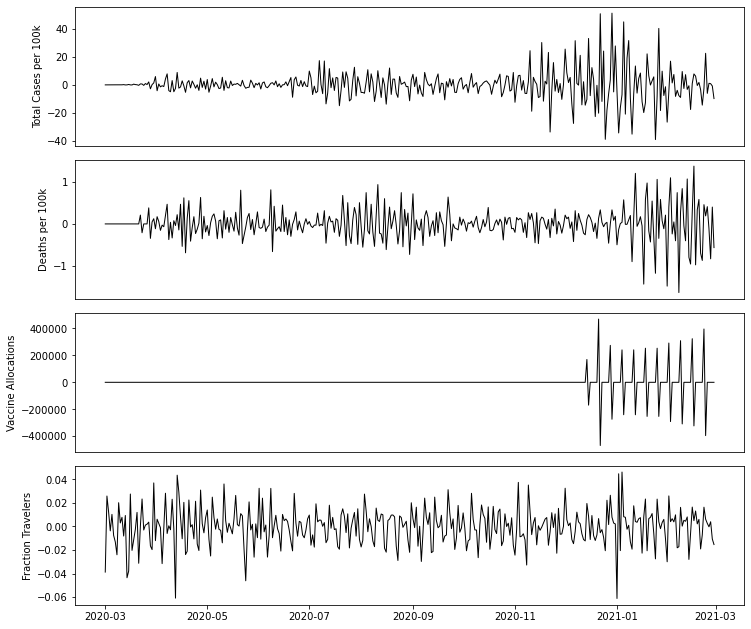

In [50]:
fig, ax = plt.subplots(4,1,figsize=(12,11))

ax[0].plot(dates[1:int(train_frac*len(vector_data))], vector_data_diff["total_cases"],color='k',lw=1)
ax[0].tick_params(axis='x',bottom=False,labelbottom=False)
ax[0].set_ylabel("Total Cases per 100k")

ax[1].plot(dates[1:int(train_frac*len(vector_data))], vector_data_diff["deaths"],color='k',lw=1)
ax[1].tick_params(axis='x',bottom=False,labelbottom=False)
ax[1].set_ylabel("Deaths per 100k")

ax[2].plot(dates[1:int(train_frac*len(vector_data))], vector_data_diff["vaccine_allocations"],color='k',lw=1)
ax[2].tick_params(axis='x',bottom=False,labelbottom=False)
ax[2].set_ylabel("Vaccine Allocations")

ax[3].plot(dates[1:int(train_frac*len(vector_data))], vector_data_diff["Population Not Staying at Home"],color='k',lw=1)
ax[3].set_ylabel("Fraction Travelers")

plt.subplots_adjust(hspace = 0.1)
plt.show()

In [51]:
# model = VAR(vector_data_diff,dates=dates[1:])
# aic_vals = []
# best_lag = None
# lag_range = np.arange(1,21,1)
# for i in lag_range:
#     result = model.fit(i)
#     aic_vals.append(result.aic)
#     if (best_lag == None) and (i > 1) and (aic_vals[-1]-aic_vals[-2] > 0):
#         best_lag = i-1

# fig = plt.figure(figsize=(12,4))

# plt.plot(lag_range, aic_vals, color='k')
# plt.axvline(best_lag,color='red',linestyle='--',label="Optimal Lag")

# plt.legend()
# plt.show()

C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


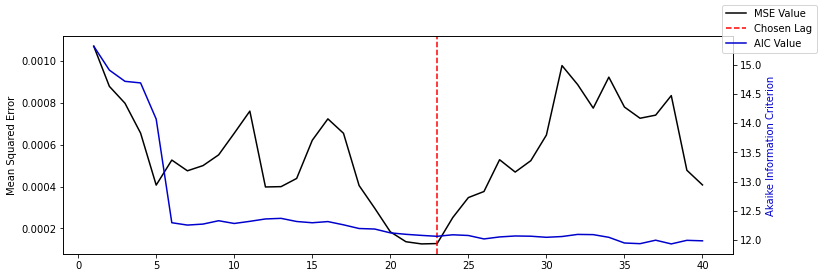

In [85]:
model = VAR(vector_data_diff)
mse_vals = []
best_mse = 1e6
aic_vals = []
lag_range = np.arange(1,41,1)
best_lag = 23
best_lag_aic = None

for i in lag_range:
    result = model.fit(i)
    
    aic_vals.append(result.aic)
    
    start_index = i
    input_data = vector_data_diff.values[-start_index:]

    forecast = result.forecast(y=input_data, steps=len(vector_data_test))
    forecast = pd.DataFrame(forecast, index=vector_data.index[-len(vector_data_test):], columns=vector_data.columns)
    forecast_copy = forecast.copy()

    cols = vector_data_train.columns
    for col in cols:        
        forecast_copy[str(col)+'_forecast'] = vector_data_train[col].iloc[-1] + forecast_copy[str(col)].cumsum()
    proper_forecast = forecast_copy.iloc[:,3:]

    mse = ((proper_forecast["Population Not Staying at Home_forecast"] - vector_data_test["Population Not Staying at Home"])**2).mean()
    mse_vals.append(mse)
    
#     if (i > 1) and (best_mse > mse):
#         best_mse = mse
#         best_lag = i
        
#     if (best_lag == None) and (i > 1) and (aic_vals[-1]-aic_vals[-2] > 0):
#         best_lag = i-1

# fig = plt.figure(figsize=(12,4))

# plt.plot(lag_range, mse_vals, color='k')
# plt.axvline(best_lag,color='red',linestyle='--',label="Optimal Lag")

# plt.legend()
# plt.show()

fig, ax1 = plt.subplots(figsize=(12,4))

ax1.plot(lag_range, mse_vals, color='k',label='MSE Value')
ax1.axvline(best_lag,color='red',linestyle='--',label="Chosen Lag")
ax1.set_ylabel("Mean Squared Error")

ax2 = ax1.twinx()

ax2.plot(lag_range, aic_vals, color='mediumblue',label='AIC Value')
ax2.set_ylabel("Akaike Information Criterion", color='mediumblue')

fig.legend()
plt.show()

In [68]:
fit_model = VAR(vector_data_diff,dates=dates[1:int(train_frac*len(vector_data))]).fit(best_lag)
fit_model.summary()

C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 04, May, 2021
Time:                     15:03:43
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    16.2347
Nobs:                     342.000    HQIC:                   13.7252
Log likelihood:          -3631.97    FPE:                    183445.
AIC:                      12.0635    Det(Omega_mle):         70089.6
--------------------------------------------------------------------
Results for equation Population Not Staying at Home
                                        coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------------
const                                      0.000633         0.000633            1.000           0.317
L1.Population Not Staying at Home         -0.410328  

In [69]:
durbin_watson(fit_model.resid)

array([1.98901348, 2.0478002 , 2.00709827, 1.99959712])

In [70]:
lag_num = fit_model.k_ar
input_data = vector_data_diff.values[-lag_num:]

In [71]:
forecast = fit_model.forecast(y=input_data, steps=len(vector_data_test))
forecast = pd.DataFrame(forecast, index=vector_data.index[-len(vector_data_test):], columns=vector_data.columns)

In [72]:
forecast_copy = forecast.copy()
cols = vector_data_train.columns
for col in cols:        
    forecast_copy[str(col)+'_forecast'] = vector_data_train[col].iloc[-1] + forecast_copy[str(col)].cumsum()
proper_forecast = forecast_copy.iloc[:,3:]
proper_forecast

,vaccine_allocations,Population Not Staying at Home_forecast,total_cases_forecast,deaths_forecast,vaccine_allocations_forecast
366,417614.594749,0.816898,19.834838,0.068881,417614.594749
367,-421790.541042,0.817304,48.445152,0.665807,-4175.946293
368,11791.920352,0.816206,34.896587,0.862294,7615.974059
369,1283.460909,0.817786,41.617427,0.738303,8899.434968
370,-8773.698892,0.813947,42.129697,0.369706,125.736076
371,6586.420145,0.810023,35.295030,0.938356,6712.156221
372,-2391.842469,0.789603,29.075610,-0.267842,4320.313752
373,396331.388856,0.820357,25.274514,-0.249915,400651.702608
374,-420490.921683,0.823630,51.258670,1.153703,-19839.219075
375,52685.366812,0.822561,38.252879,0.706572,32846.147737


In [73]:
np.array((proper_forecast["Population Not Staying at Home_forecast"] - vector_data_test["Population Not Staying at Home"])**2).mean()

0.00012772104079135526

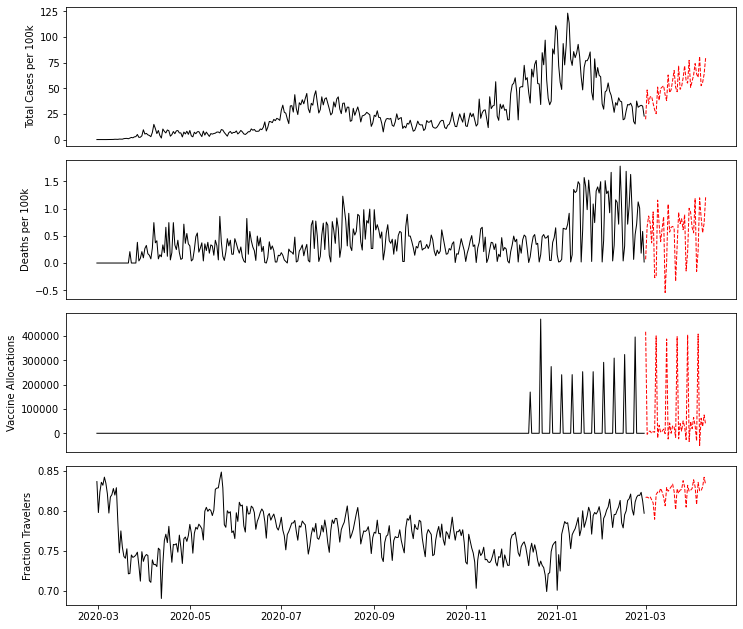

In [74]:
fig, ax = plt.subplots(4,1,figsize=(12,11))

ax[0].plot(dates[:int(train_frac*len(vector_data))],vector_data_train["total_cases"],color='k',lw=1)
ax[0].plot(dates[int(train_frac*len(vector_data)):],proper_forecast["total_cases_forecast"],color='r',lw=1,linestyle='--')
ax[0].tick_params(axis='x',bottom=False,labelbottom=False)
ax[0].set_ylabel("Total Cases per 100k")

ax[1].plot(dates[:int(train_frac*len(vector_data))],vector_data_train["deaths"],color='k',lw=1)
ax[1].plot(dates[int(train_frac*len(vector_data)):],proper_forecast["deaths_forecast"],color='r',lw=1,linestyle='--')
ax[1].tick_params(axis='x',bottom=False,labelbottom=False)
ax[1].set_ylabel("Deaths per 100k")

ax[2].plot(dates[:int(train_frac*len(vector_data))],vector_data_train["vaccine_allocations"],color='k',lw=1)
ax[2].plot(dates[int(train_frac*len(vector_data)):],proper_forecast["vaccine_allocations_forecast"],color='r',lw=1,linestyle='--')
ax[2].tick_params(axis='x',bottom=False,labelbottom=False)
ax[2].set_ylabel("Vaccine Allocations")

ax[3].plot(dates[:int(train_frac*len(vector_data))],vector_data_train["Population Not Staying at Home"],color='k',lw=1)
ax[3].plot(dates[int(train_frac*len(vector_data)):],proper_forecast["Population Not Staying at Home_forecast"],color='r',lw=1,linestyle='--')
ax[3].set_ylabel("Fraction Travelers")

plt.subplots_adjust(hspace = 0.1)
plt.show()

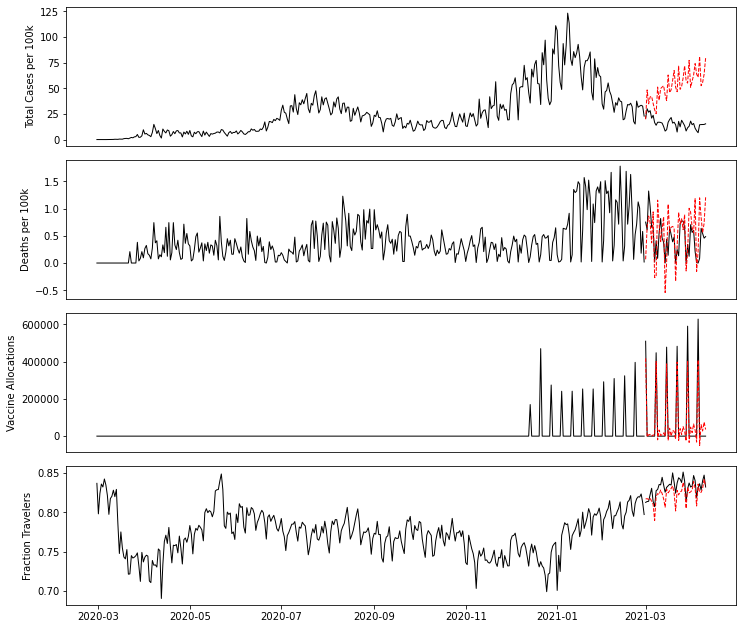

In [75]:
fig, ax = plt.subplots(4,1,figsize=(12,11))

ax[0].plot(dates[:int(train_frac*len(vector_data))],vector_data_train["total_cases"],color='k',lw=1)
ax[0].plot(dates[int(train_frac*len(vector_data)):],vector_data_test["total_cases"],color='k',lw=1)#,linestyle='--')
ax[0].plot(dates[int(train_frac*len(vector_data)):],proper_forecast["total_cases_forecast"],color='r',lw=1,linestyle='--')
ax[0].tick_params(axis='x',bottom=False,labelbottom=False)
ax[0].set_ylabel("Total Cases per 100k")

ax[1].plot(dates[:int(train_frac*len(vector_data))],vector_data_train["deaths"],color='k',lw=1)
ax[1].plot(dates[int(train_frac*len(vector_data)):],vector_data_test["deaths"],color='k',lw=1)#,linestyle='--')
ax[1].plot(dates[int(train_frac*len(vector_data)):],proper_forecast["deaths_forecast"],color='r',lw=1,linestyle='--')
ax[1].tick_params(axis='x',bottom=False,labelbottom=False)
ax[1].set_ylabel("Deaths per 100k")

ax[2].plot(dates[:int(train_frac*len(vector_data))],vector_data_train["vaccine_allocations"],color='k',lw=1)
ax[2].plot(dates[int(train_frac*len(vector_data)):],vector_data_test["vaccine_allocations"],color='k',lw=1)#,linestyle='--')
ax[2].plot(dates[int(train_frac*len(vector_data)):],proper_forecast["vaccine_allocations_forecast"],color='r',lw=1,linestyle='--')
ax[2].tick_params(axis='x',bottom=False,labelbottom=False)
ax[2].set_ylabel("Vaccine Allocations")

ax[3].plot(dates[:int(train_frac*len(vector_data))],vector_data_train["Population Not Staying at Home"],color='k',lw=1)
ax[3].plot(dates[int(train_frac*len(vector_data)):],vector_data_test["Population Not Staying at Home"],color='k',lw=1)#,linestyle='--')
ax[3].plot(dates[int(train_frac*len(vector_data)):],proper_forecast["Population Not Staying at Home_forecast"],color='r',lw=1,linestyle='--')
ax[3].set_ylabel("Fraction Travelers")

plt.subplots_adjust(hspace = 0.1)
plt.show()

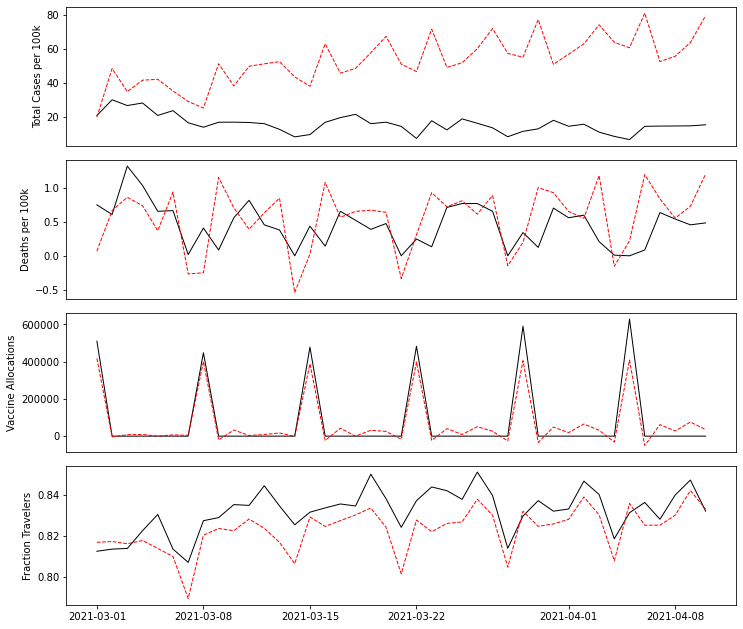

In [76]:
fig, ax = plt.subplots(4,1,figsize=(12,11))

ax[0].plot(dates[int(train_frac*len(vector_data)):],vector_data_test["total_cases"],color='k',lw=1)
ax[0].plot(dates[int(train_frac*len(vector_data)):],proper_forecast["total_cases_forecast"],color='r',lw=1,linestyle='--')
ax[0].tick_params(axis='x',bottom=False,labelbottom=False)
ax[0].set_ylabel("Total Cases per 100k")

ax[1].plot(dates[int(train_frac*len(vector_data)):],vector_data_test["deaths"],color='k',lw=1)
ax[1].plot(dates[int(train_frac*len(vector_data)):],proper_forecast["deaths_forecast"],color='r',lw=1,linestyle='--')
ax[1].tick_params(axis='x',bottom=False,labelbottom=False)
ax[1].set_ylabel("Deaths per 100k")

ax[2].plot(dates[int(train_frac*len(vector_data)):],vector_data_test["vaccine_allocations"],color='k',lw=1)
ax[2].plot(dates[int(train_frac*len(vector_data)):],proper_forecast["vaccine_allocations_forecast"],color='r',lw=1,linestyle='--')
ax[2].tick_params(axis='x',bottom=False,labelbottom=False)
ax[2].set_ylabel("Vaccine Allocations")

ax[3].plot(dates[int(train_frac*len(vector_data)):],vector_data_test["Population Not Staying at Home"],color='k',lw=1)
ax[3].plot(dates[int(train_frac*len(vector_data)):],proper_forecast["Population Not Staying at Home_forecast"],color='r',lw=1,linestyle='--')
ax[3].set_ylabel("Fraction Travelers")

plt.subplots_adjust(hspace = 0.1)
plt.show()